In [1]:
import sys
sys.path.append("../../src/earthtext")

from earthtext.osm import multilabel
import rasterio
import xarray as xr
import os
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from osm import osm
from osm import multilabel
from collections import OrderedDict
import pandas as pd
from progressbar import progressbar as pbar
from joblib import Parallel, delayed
from pyproj import CRS
import numpy as np
epsg4326 = CRS.from_epsg(4326)

get_region_hash = osm.get_region_hash

In [2]:
imgs_folder    = "/opt/data/"
osmobjs_folder = "/opt/data/california-naip-chips/osm"
master_index   = "/opt/data/california-naip-chips/california-naip-chips-100k.parquet"
osm_codeset    = 'naip'

In [3]:
from importlib import reload
reload(multilabel)
iosdata = multilabel.ImageOSMData(imgs_folder=imgs_folder, osmobjs_folder=osmobjs_folder, master_index=master_index, osm_codeset=osm_codeset).init_index(compute_hashid=False)

In [4]:
iosdata.m.shape

(113160, 8)

In [5]:
c = iosdata.sample_chip().read_osm()

In [6]:
c.osm

,tags,geometry,kind,length,area,stags,chip_id
4240905208,{'highway': 'stop'},POINT (-118.56309 34.19396),node,0.000000,0.000000,highway: stop,1cd129c753f0a
4295070500,{'highway': 'stop'},POINT (-118.56389 34.19411),node,0.000000,0.000000,highway: stop,1cd129c753f0a
4295070501,{'highway': 'stop'},POINT (-118.56328 34.19411),node,0.000000,0.000000,highway: stop,1cd129c753f0a
4295070502,{'highway': 'stop'},POINT (-118.56369 34.19411),node,0.000000,0.000000,highway: stop,1cd129c753f0a
4295070507,{'highway': 'stop'},POINT (-118.56349 34.19411),node,0.000000,0.000000,highway: stop,1cd129c753f0a
6543607265,{'highway': 'stop'},POINT (-118.56304 34.19443),node,0.000000,0.000000,highway: stop,1cd129c753f0a
8349,"{'highway': 'service', 'service': 'alley'}","LINESTRING (-118.56282 34.19334, -118.56282 34...",way,27.698865,0.000000,highway: service\n<br>\nservice: alley,1cd129c753f0a
8354,"{'highway': 'service', 'service': 'alley'}","LINESTRING (-118.56394 34.19333, -118.56392 34...",way,80.075964,0.000000,highway: service\n<br>\nservice: alley,1cd129c753f0a
14283,{'highway': 'secondary'},"LINESTRING (-118.56395 34.19383, -118.56392 34...",way,74.122060,0.000000,highway: secondary,1cd129c753f0a
14285,{'highway': 'secondary'},"LINESTRING (-118.56315 34.19383, -118.56309 34...",way,79.529942,0.000000,highway: secondary,1cd129c753f0a


In [7]:
z, zs = c.get_onehot()

In [8]:
z

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
area,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
length,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

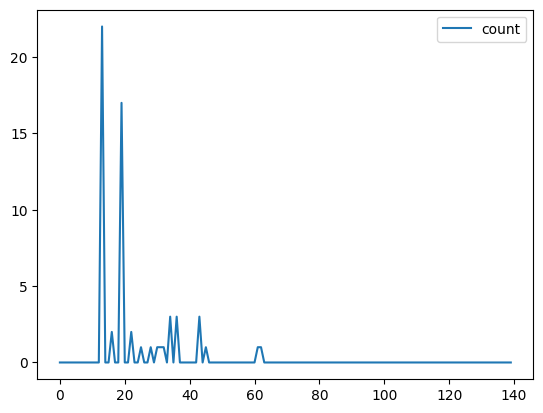

In [9]:
z.loc[['count']].T.plot()

In [10]:
z.loc['count'][z.loc['count']!=0], zs

(13    22.0
 16     2.0
 19    17.0
 22     2.0
 25     1.0
 28     1.0
 30     1.0
 31     1.0
 32     1.0
 34     3.0
 36     3.0
 43     3.0
 45     1.0
 61     1.0
 62     1.0
 Name: count, dtype: float64,
 ['building=*',
  'building=commercial',
  'building=house',
  'building=retail',
  'building=yes',
  'crossing=*',
  'crossing=traffic_signals',
  'footway=*',
  'footway=crossing',
  'highway=*',
  'highway=footway',
  'landuse=*',
  'landuse=commercial',
  'landuse=residential',
  'landuse=retail'])

In [11]:
{i: multilabel.OSMCodeSets.get(osm_codeset)['kvmerged'].inverse_codes[i] for i in z.loc['count'][z.loc['count']!=0].index}

{13: 'building=*',
 16: 'building=commercial',
 19: 'building=house',
 22: 'building=retail',
 25: 'building=yes',
 28: 'crossing=*',
 30: 'crossing=traffic_signals',
 31: 'footway=*',
 32: 'footway=crossing',
 34: 'highway=*',
 36: 'highway=footway',
 43: 'landuse=*',
 45: 'landuse=commercial',
 61: 'landuse=residential',
 62: 'landuse=retail'}

## create the multilabels

In [46]:
while True:
    splits = np.linspace(0, len(iosdata.m), 20).astype(int)
    splits[-1]+=1
    splits = [[splits[i], splits[i+1]] for i in range(len(splits)-1)]
    splits = np.random.permutation(splits)
    if splits[0][0] == 17671:
        break
splits

KeyboardInterrupt: 

In [12]:
splits = np.linspace(0, len(iosdata.m), 20).astype(int)
splits[-1]+=1
splits = [[splits[i], splits[i+1]] for i in range(len(splits)-1)]
splits = np.random.permutation(splits)
splits

array([[  5955,  11911],
       [ 83381,  89336],
       [ 35734,  41690],
       [ 11911,  17867],
       [107204, 113161],
       [ 71469,  77425],
       [ 17867,  23823],
       [ 65513,  71469],
       [101248, 107204],
       [ 95292, 101248],
       [ 47646,  53602],
       [ 23823,  29778],
       [ 29778,  35734],
       [ 89336,  95292],
       [     0,   5955],
       [ 53602,  59557],
       [ 59557,  65513],
       [ 41690,  47646],
       [ 77425,  83381]])

In [13]:
from rlxutils import ElapsedTimes
et = ElapsedTimes()

In [14]:
ImageOSMChip = multilabel.ImageOSMChip
r = []
chip_ids = []


In [19]:
from importlib import reload
reload(multilabel)
ImageOSMChip = multilabel.ImageOSMChip


In [20]:
for start,end in splits:
    print (f"\n{start} : {end}", flush=True)
    for chip_id in pbar(iosdata.m.index[start:end]):
        if chip_id in chip_ids:
            continue
        try:
            with et("load"):
                keyval_onehot,keyval_strs = ImageOSMChip(iosdata, chip_id).read_osm().get_onehot()
                if keyval_onehot is None:
                    continue
            with et("extract"):
                onehot_area = keyval_onehot.loc['area'].values.copy()
                onehot_count = keyval_onehot.loc['count'].values.copy()
                onehot_length = keyval_onehot.loc['length'].values.copy()
                keyval_strs = [i for i in keyval_strs]
            with et("append"):
                r.append([chip_id, onehot_count, onehot_area, onehot_length, keyval_strs])
                chip_ids.append(chip_id)
        except Exception as e:
            raise e
            
    


5955 : 11911


100% (5956 of 5956) |####################| Elapsed Time: 0:00:09 Time:  0:00:090000



83381 : 89336


100% (5955 of 5955) |####################| Elapsed Time: 0:00:09 Time:  0:00:090000



35734 : 41690


100% (5956 of 5956) |####################| Elapsed Time: 0:00:07 Time:  0:00:070000



11911 : 17867


100% (5956 of 5956) |####################| Elapsed Time: 0:03:05 Time:  0:03:050115



107204 : 113161


100% (5956 of 5956) |####################| Elapsed Time: 0:03:06 Time:  0:03:060115



71469 : 77425


100% (5956 of 5956) |####################| Elapsed Time: 0:03:11 Time:  0:03:110115



17867 : 23823


100% (5956 of 5956) |####################| Elapsed Time: 0:03:09 Time:  0:03:090115



65513 : 71469


100% (5956 of 5956) |####################| Elapsed Time: 0:03:11 Time:  0:03:110115



101248 : 107204


100% (5956 of 5956) |####################| Elapsed Time: 0:03:11 Time:  0:03:110115



95292 : 101248


100% (5956 of 5956) |####################| Elapsed Time: 0:03:09 Time:  0:03:090115



47646 : 53602


 65% (3902 of 5956) |#############       | Elapsed Time: 0:02:03 ETA:   0:01:04IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100% (5955 of 5955) |####################| Elapsed Time: 0:03:10 Time:  0:03:100115



53602 : 59557


100% (5955 of 5955) |####################| Elapsed Time: 0:03:24 Time:  0:03:240116



59557 : 65513


100% (5956 of 5956) |####################| Elapsed Time: 0:03:15 Time:  0:03:150115



41690 : 47646


100% (5956 of 5956) |####################| Elapsed Time: 0:03:12 Time:  0:03:120115



77425 : 83381


100% (5956 of 5956) |####################| Elapsed Time: 0:03:14 Time:  0:03:140115


## create dataframe with multilabels

In [21]:
len(r)

104240

In [22]:
rr = pd.DataFrame(r, columns=['chip_id', 'onehot_count', 'onehot_area', 'onehot_length', 'string_labels'])
rr.set_index('chip_id', inplace=True)
rr['onehot_count'] = [i.astype(np.int32) for i in rr.onehot_count.values]

In [23]:
rr.head()

,onehot_count,onehot_area,onehot_length,string_labels
chip_id,,,,
2aa6edd542c04,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[highway=*, highway=residential, landuse=*, la..."
263c35b6bc2de,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[highway=*, highway=track, natural=*, natural=..."
03727d6e08a60,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[highway=*, highway=residential]"
15feffc8237b1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[building=*, building=house, highway=*, highwa..."
3507df52f7a00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[highway=*, highway=residential]"


In [24]:
rv = pd.DataFrame(np.r_[[list(i>0) for i in rr.onehot_count.values]])

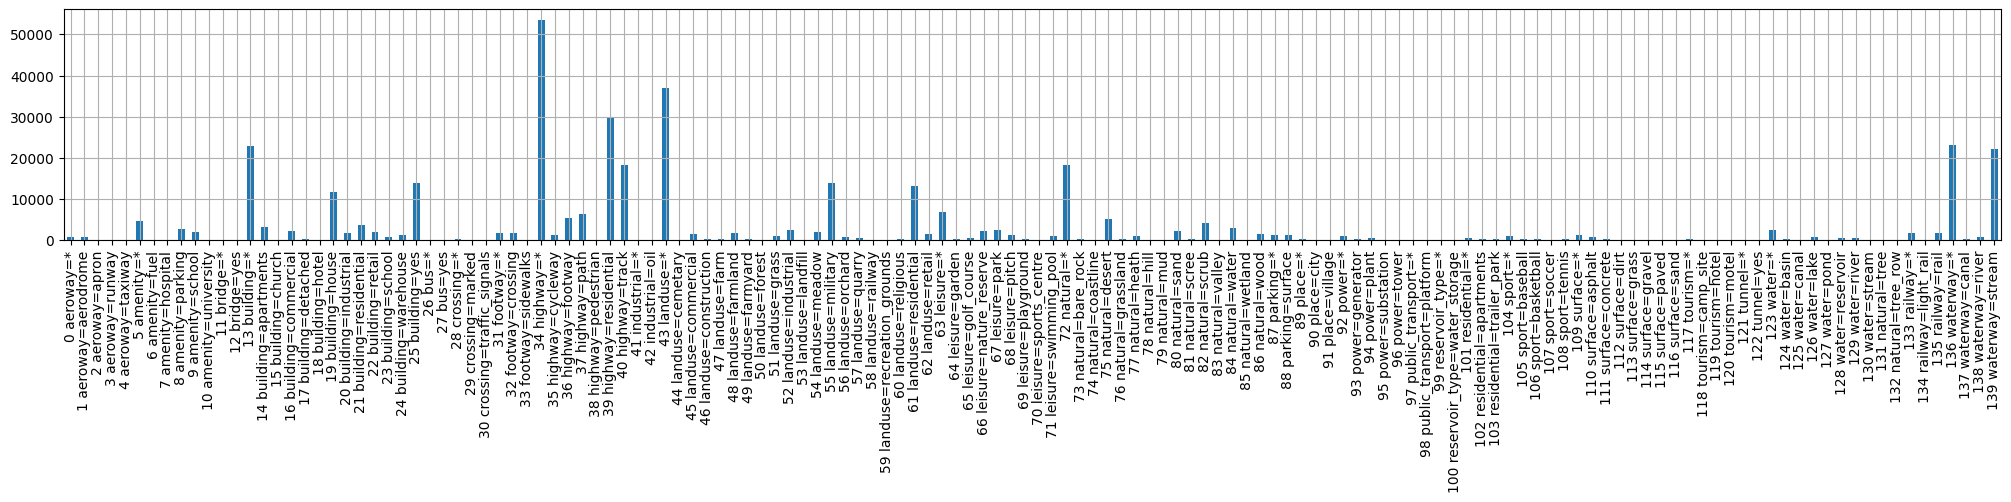

In [36]:
rv.sum(axis=0).plot(kind='bar', figsize=(25,3))
plt.grid();
codeset = multilabel.OSMCodeSets.get(osm_codeset)['kvmerged'].inverse_codes
plt.xticks(range(len(codeset)), [f"{i} {codeset[i]}" for i in range(len(codeset))]);


## join with original metadata dataframe

In [37]:
rohem = gpd.GeoDataFrame(rr.join(iosdata.m), crs=epsg4326)
rohem


,onehot_count,onehot_area,onehot_length,string_labels,date,chip_index_x,chip_index_y,cloud_cover_percentage,nodata_percentage,geometry,embeddings,original_chip_id
chip_id,,,,,,,,,,,,
2aa6edd542c04,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[highway=*, highway=residential, landuse=*, la...",2022-05-01,11,19,0.0,0.0,"POLYGON ((-117.35728 34.53802, -117.35728 34.5...","[-0.18207408, 0.010965488, 0.14534824, 0.01129...",ca_m_3411730_sw_11_060_20220501-11-19
263c35b6bc2de,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[highway=*, highway=track, natural=*, natural=...",2022-05-01,18,27,0.0,0.0,"POLYGON ((-117.34552 34.52698, -117.34551 34.5...","[-0.12799226, 0.016031748, 0.14097819, -0.0078...",ca_m_3411730_sw_11_060_20220501-18-27
03727d6e08a60,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[highway=*, highway=residential]",2022-05-01,26,32,0.0,0.0,"POLYGON ((-117.33210 34.52009, -117.33210 34.5...","[-0.17556956, 0.027415793, 0.1394226, 0.014260...",ca_m_3411730_sw_11_060_20220501-26-32
15feffc8237b1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[building=*, building=house, highway=*, highwa...",2022-05-01,34,15,0.0,0.0,"POLYGON ((-117.31880 34.54367, -117.31880 34.5...","[-0.15264373, 0.02538409, 0.16069295, 0.021494...",ca_m_3411730_sw_11_060_20220501-34-15
3507df52f7a00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[highway=*, highway=residential]",2022-05-01,39,15,0.0,0.0,"POLYGON ((-117.31043 34.54369, -117.31043 34.5...","[-0.15472408, 0.021862868, 0.15023148, 0.01503...",ca_m_3411730_sw_11_060_20220501-39-15
...,...,...,...,...,...,...,...,...,...,...,...,...
1bfb03fb24425,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[natural=*, natural=water, water=*, water=rive...",2022-05-01,0,6,0.0,0.0,"POLYGON ((-117.31322 34.05601, -117.31322 34.0...","[-0.13514405, 0.028997052, 0.16110343, 0.01697...",ca_m_3411762_se_11_060_20220501-0-6
06041fdf29c2a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[highway=*, highway=path]",2022-05-01,29,25,0.0,0.0,"POLYGON ((-117.26487 34.02980, -117.26487 34.0...","[-0.13731167, 0.03338281, 0.14600858, 0.003292...",ca_m_3411762_se_11_060_20220501-29-25
173b439efb982,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[building=*, building=yes, highway=*, highway=...",2022-05-01,16,4,0.0,0.0,"POLYGON ((-117.28660 34.05884, -117.28660 34.0...","[-0.14825878, 0.03165315, 0.15159926, 0.008990...",ca_m_3411762_se_11_060_20220501-16-4


In [38]:
rohem.to_parquet(master_index)

## visualize some chip

In [39]:
chip_id = rohem.index[np.random.randint(len(rohem))]
c = multilabel.ImageOSMChip(iosdata, chip_id).read_osm()

In [40]:
c.osm

,tags,geometry,kind,length,area,stags,chip_id
123074711,{'highway': 'traffic_signals'},POINT (-118.08583 34.01204),node,0.000000,0.000000,highway: traffic_signals,2453c16253800
27,{'highway': 'secondary'},"LINESTRING (-118.08583 34.01204, -118.08583 34...",way,1.144894,0.000000,highway: secondary,2453c16253800
3422,{'highway': 'residential'},"LINESTRING (-118.08741 34.01097, -118.08712 34...",way,123.245961,0.000000,highway: residential,2453c16253800
10238,{'highway': 'residential'},"LINESTRING (-118.08654 34.01150, -118.08664 34...",way,94.582216,0.000000,highway: residential,2453c16253800
11263,{'highway': 'residential'},"LINESTRING (-118.08742 34.01179, -118.08654 34...",way,87.598275,0.000000,highway: residential,2453c16253800
13706,{'highway': 'secondary'},"LINESTRING (-118.08583 34.01204, -118.08576 34...",way,6.555393,0.000000,highway: secondary,2453c16253800
38821,"{'highway': 'secondary', 'surface': 'asphalt'}","LINESTRING (-118.08597 34.01072, -118.08587 34...",way,75.367462,0.000000,highway: secondary\n<br>\nsurface: asphalt,2453c16253800
38842,{'highway': 'secondary'},"LINESTRING (-118.08587 34.01139, -118.08583 34...",way,71.364427,0.000000,highway: secondary,2453c16253800
38862,"{'highway': 'secondary', 'surface': 'asphalt'}","LINESTRING (-118.08597 34.01066, -118.08597 34...",way,6.597398,0.000000,highway: secondary\n<br>\nsurface: asphalt,2453c16253800
38864,"{'highway': 'secondary', 'surface': 'asphalt'}","LINESTRING (-118.08598 34.01205, -118.08602 34...",way,145.822634,0.000000,highway: secondary\n<br>\nsurface: asphalt,2453c16253800


In [41]:
keyval_onehot,keyval_strs = c.get_onehot()

In [42]:
keyval_strs

['building=*',
 'building=house',
 'building=industrial',
 'building=retail',
 'building=yes',
 'highway=*',
 'highway=residential',
 'landuse=*',
 'landuse=residential']

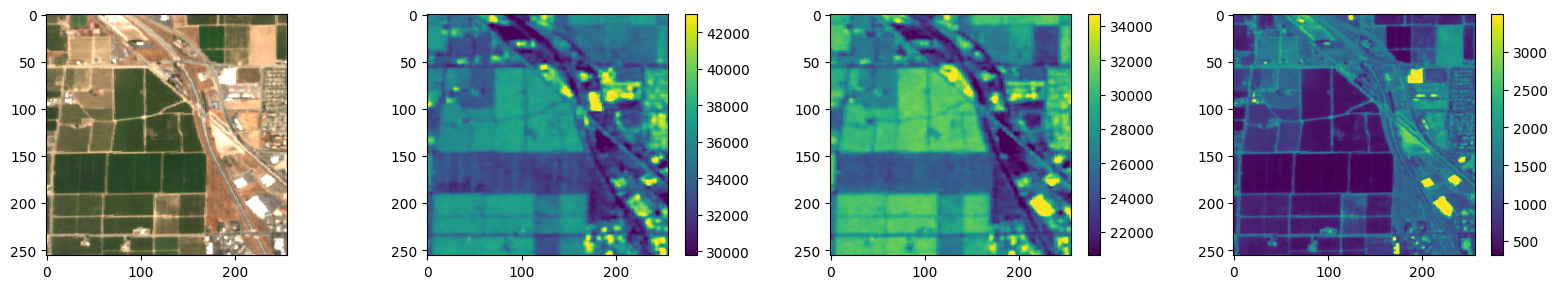

In [249]:
c.show()